In [1]:
! pip install plotly
! pip install pandas
! pip install matplotlib
! pip install openpyxl
! pip install nbformat 


In [2]:
from rest.base import OdooAPIKey, ProductClient, OdooClient, OdooAPIBase
import os
# 设置环境变量
os.environ['ODOO_ACCESS_KEY'] = 'odoo-api-prod.json'
os.environ['ODOO_ACCESS_KEY_INDEX'] = "0"

api_key = OdooAPIKey.prod()
base = OdooAPIBase(api_key)
cli = base.client


Odoo API Login


### **1.1 总销售额（Revenue/Sales Volume）**
- **含义**：
  - 统计每个月的销售总额，即所有销售订单的总金额。
  - 公式：`总销售额 = 每个产品的售价 × 销售数量（扣除退款或退货金额）`。
- **用途**：
  - 衡量整体销售表现。
  - 分析季节性趋势或特定促销活动对销售的影响。

In [3]:
# Get Order Details
domain = [('user_id', 'not in', [8, 6])]
order_ids = cli.search('sale.order', [domain])
orders_ = cli.read('sale.order', [order_ids])
print(orders_[0])


{'id': 629, 'campaign_id': False, 'source_id': False, 'medium_id': False, 'activity_ids': [], 'activity_state': False, 'activity_user_id': False, 'activity_type_id': False, 'activity_type_icon': False, 'activity_date_deadline': False, 'my_activity_date_deadline': False, 'activity_summary': False, 'activity_exception_decoration': False, 'activity_exception_icon': False, 'activity_calendar_event_id': False, 'message_is_follower': True, 'message_follower_ids': [5084], 'message_partner_ids': [3], 'message_ids': [13347], 'has_message': True, 'message_needaction': False, 'message_needaction_counter': 0, 'message_has_error': False, 'message_has_error_counter': 0, 'message_attachment_count': 0, 'rating_ids': [], 'website_message_ids': [], 'message_has_sms_error': False, 'access_url': '/my/orders/629', 'access_token': False, 'access_warning': '', 'name': 'AB250562801', 'company_id': [1, 'HansaGT Medical GmbH'], 'partner_id': [47656, 'Marien - Apotheke'], 'state': 'draft', 'locked': False, 'clie

In [4]:
orders_[100]

{'id': 492,
 'campaign_id': False,
 'source_id': False,
 'medium_id': False,
 'activity_ids': [],
 'activity_state': False,
 'activity_user_id': False,
 'activity_type_id': False,
 'activity_type_icon': False,
 'activity_date_deadline': False,
 'my_activity_date_deadline': False,
 'activity_summary': False,
 'activity_exception_decoration': False,
 'activity_exception_icon': False,
 'activity_calendar_event_id': False,
 'message_is_follower': True,
 'message_follower_ids': [3516, 3517, 3521, 3522],
 'message_partner_ids': [3, 267, 10140, 7],
 'message_ids': [10388, 9341, 9338, 9337, 9336, 9333, 9330],
 'has_message': True,
 'message_needaction': False,
 'message_needaction_counter': 0,
 'message_has_error': False,
 'message_has_error_counter': 0,
 'message_attachment_count': 2,
 'rating_ids': [],
 'website_message_ids': [9338],
 'message_has_sms_error': False,
 'access_url': '/my/orders/492',
 'access_token': '5fa6ef9b-48fd-458b-8cec-92ffe2513bbd',
 'access_warning': '',
 'name': 'AB24

In [5]:
# 获取所有orderline的id
order_line_ids = set()
for od in orders_:
    order_line_ids.update(od['order_line'])

order_line_ids = list(order_line_ids)

print(f"Length: {len(order_line_ids)}")
print(order_line_ids[:10])

Length: 916
[298, 299, 300, 301, 302, 303, 304, 305, 332, 333]


In [6]:
orderlines_ = cli.read('sale.order.line', [order_line_ids])
orderlines_[50]

{'id': 585,
 'analytic_distribution': False,
 'analytic_distribution_search': False,
 'analytic_precision': 2,
 'order_id': [279, 'AB240527707'],
 'sequence': 13,
 'company_id': [1, 'HansaGT Medical GmbH'],
 'currency_id': [126, 'EUR'],
 'order_partner_id': [288,
  'Diakoniestiftung Alt-Hamburg - St. Gertrud Gemeindepflege Alten- und Pflegeheim'],
 'salesman_id': [7, 'Alexander Haliw'],
 'state': 'sale',
 'tax_country_id': [57, 'Germany'],
 'display_type': False,
 'is_downpayment': False,
 'is_expense': False,
 'product_id': [1302,
  '[MPC- 118245] MP Med® Andickungspulver PLUS Neutral 850 g'],
 'product_template_id': [4150,
  '[MPC- 118245] MP Med® Andickungspulver PLUS Neutral 850 g'],
 'product_uom_category_id': [1, 'Unit'],
 'product_custom_attribute_value_ids': [],
 'product_no_variant_attribute_value_ids': [],
 'name': '[MPM- A21210014] MP Med® Andickungspulver PLUS Neutral 850 g',
 'product_uom_qty': 12.0,
 'product_uom': [35, 'Bucket'],
 'tax_id': [16],
 'pricelist_item_id': [3

In [7]:
from typing import List, Union
from pydantic import BaseModel
import pandas as pd

sale_orders = []

for od in orders_:
    so = dict(
        id = od['id'],
        name = od['name'],
        company = od['company_id'][1],
        partner = od['partner_id'][1],
        state = od['state'],
        date_order = od['date_order'],
        invoice_status = od['invoice_status'],
        shipping_weight = od['shipping_weight'],
        orderline_ids = od['order_line']
    )
    sale_orders.append(so)

print(f"Number of orders: {len(sale_orders)}")

df_sale_order = pd.DataFrame.from_dict(sale_orders)
df_sale_order.to_excel("data/sales_order.xlsx", index=False)

Number of orders: 296


In [8]:
orderlines = []

for odl in orderlines_:    
    if odl['display_type'] == 'line_note':
        continue
    try:
        line = {
            "order_number": odl['order_id'][1],  # 订单号
            "product_name": odl['name'],  
            "currency": odl['currency_id'][1], 
            "order_partner": odl['order_partner_id'][1], # 客户
            "salesman": odl['salesman_id'][1], # 销售员
            'state': odl['state'], 
            'uom': odl['product_uom'][1],  # 单位
            'product_uom_qty': odl['product_uom_qty'],   #product_qty
            'product_qty': odl['product_qty'],  # 数量
            'price_unit': odl['price_unit'],  # 单价
            'price_subtotal': odl['price_subtotal'], # 小计
            'price_tax': odl['price_tax'], # 含税
            'price_total': odl['price_total'], # 总计
            'qty_to_invoice': odl['qty_to_invoice'], 
            'qty_to_deliver': odl['qty_to_deliver'],
            'product_type': odl['product_type'],
            'create_date': odl['create_date'],            
            'is_delivery': odl['is_delivery'],    
            # 'discount': odl['discount'],                       
        }
    except Exception as e:
        print(e)
        print(odl)
    orderlines.append(line)
df_sale_order_lines = pd.DataFrame.from_dict(orderlines)
df_sale_order_lines['create_date'] = pd.to_datetime(df_sale_order_lines['create_date'], format='%Y-%m-%d %H:%M:%S')
df_sale_order_lines.sort_values(by='create_date', inplace=True)
df_sale_order_lines.to_excel('data/sales_order_lines.xlsx')


In [9]:
import datetime
# 数据清洗

# 被取消的orderlines
df_filtered_orderlines = df_sale_order_lines[df_sale_order_lines['state']== 'sale']

# 过去180天内的订单
today = datetime.datetime.now()
past_days = today - datetime.timedelta(days=180)
df_filtered_orderlines = df_filtered_orderlines[df_filtered_orderlines['create_date'] >= past_days]

# product_type == product
df_filtered_orderlines = df_filtered_orderlines[df_filtered_orderlines['product_type']== 'product']
# qty_to_invoice == 0 and qty_to_deliver == 0
qty_to_invoice_zero = df_filtered_orderlines['qty_to_invoice'] == 0
qty_to_deliver_zero = df_filtered_orderlines['qty_to_deliver'] == 0
df_filtered_orderlines = df_filtered_orderlines[qty_to_invoice_zero & qty_to_deliver_zero]

# price_unit != 0
df_filtered_orderlines = df_filtered_orderlines[df_filtered_orderlines['price_unit']!= 0]

# Create month, year columns, 2024-07-25 10:46:01 to 2024-07
df_filtered_orderlines['year'] = df_filtered_orderlines['create_date'].dt.strftime('%Y')
df_filtered_orderlines['month'] = df_filtered_orderlines['create_date'].dt.strftime('%Y-%m')

df_filtered_orderlines.to_excel('data/sales_order_lines.xlsx')
len(df_filtered_orderlines)


694

## 按订单号聚合

In [32]:
odoo_sales_orderlines = df_filtered_orderlines.copy()
# 按订单号聚合订单明细.
df_agg_orderlines = odoo_sales_orderlines.groupby('order_number')  \
    .agg({'create_date': 'first', 
          'order_partner': 'first', 'salesman': 'first', 
          'price_tax': 'sum',  'price_subtotal': 'sum'}) \
    .reset_index()

df_agg_orderlines.head(10)

,order_number,create_date,order_partner,salesman,price_tax,price_subtotal
0,AB240527107,2024-07-25 10:46:01,Alten- und Pflegeheim St. Elisabeth,Alexander Haliw,98.56,518.76
1,AB240527207,2024-07-26 09:17:37,AWO Bezirk Hannover gGmbH,Alexander Haliw,62.99,331.50
2,AB240527307,2024-07-29 14:20:41,Haus Itzstedt,Alexander Haliw,49.94,262.80
3,AB240527407,2024-07-30 11:26:50,Senioren- und Pflegeheim Elbuferpark,Alexander Haliw,38.96,205.00
4,AB240527507,2024-07-30 12:41:19,Gesundheits- und Pflegezentrum Goldenherz,Alexander Haliw,503.58,2650.38
5,AB240527607,2024-07-30 12:55:29,Hanse Medical GmbH,Alexander Haliw,7.94,41.80
6,AB240527707,2024-07-31 09:53:35,Diakoniestiftung Alt-Hamburg - St. Gertrud Gem...,Alexander Haliw,98.60,518.88
7,AB240527807,2024-07-31 12:35:43,Hospiz Sinus Othmarschen,Alexander Haliw,48.40,254.74
8,AB240528008,2024-08-01 09:33:10,Diakoniestiftung Alt-Hamburg - Bodemann Heim,Alexander Haliw,117.28,617.33
9,AB240528108,2024-08-01 11:08:55,Alten- und Pflegeheim Bellevue,Alexander Haliw,86.38,454.68


## 统计每一个客户的销售额 (不含运费，不含未结的)

### 基于 RFM 模型
RFM 是一种经典的客户分析模型，基于以下三个维度计算客户忠诚度：

1. Recency（最近一次购买时间）：
  - 距离最近一次购买时间的天数，值越小表明客户越活跃。
2. Frequency（购买频率）：
  - 客户的总购买次数，值越大表明客户越忠诚。
3. Monetary（消费金额）：
  - 客户的总消费金额，值越大表明客户贡献越高。

In [33]:
import time 
import numpy as np

def classify_customer(row):
    """
    Classify customers into different types based on their RFM scores.
    """
    # 高价值客户: 忠诚度评分较高，购买金额、频率较高，且最近购买时间较短。
    if row['loyalty_score'] >= 4.0:
        return 'High-Value Customers'
    # 潜在流失客户: 最近购买时间较久，频率较高，曾经是重要客户，但可能流失。
    elif row['recency_score'] in [1, 2] and row['frequency_score'] >= 4 and row['monetary_score'] >= 4:
        return 'At-Risk Customers'
    # 新客户: 最近购买时间短，但购买频率和金额较低。
    elif row['recency_score'] >= 4 and row['frequency_score'] <= 2 and row['monetary_score'] <= 2:
        return 'New Customers'
    # 其他客户
    else:
        return 'Others'
    
reference_date = pd.Timestamp.now()
# 统计每一个客户的销售额 (不含运费，不含未结的)
df_customer_sales = odoo_sales_orderlines.groupby('order_partner') \
                        .agg({'price_subtotal': sum, 'currency': 'first', 'order_number': 'nunique'}) \
                        # .reset_index()

df_customer_sales = df_customer_sales.rename(columns={'order_number': 'order_count'})

df_customer_sales = df_customer_sales.sort_values('price_subtotal', ascending=False)
df_customer_sales['avg_order_price'] = df_customer_sales['price_subtotal'] / df_customer_sales['order_count']
df_customer_sales['avg_order_price'] = df_customer_sales['avg_order_price'].round(2)

# 距离上次购买时间 (天)
last_order_days = odoo_sales_orderlines.groupby('order_partner')['create_date'].max().reset_index()
last_order_days['last_order_days'] = (reference_date - last_order_days['create_date']).dt.days
df_customer_sales = pd.merge(df_customer_sales, last_order_days[['order_partner', 'last_order_days']], on='order_partner', how='left')

# 订单金额评分
df_customer_sales['monetary_score'] = pd.qcut(df_customer_sales['price_subtotal'], 5, labels=[1, 2, 3, 4, 5])
# 订单次数评分
df_customer_sales['noisy_order_count'] = df_customer_sales['order_count'] + np.random.uniform(0, 0.01, size=len(df_customer_sales))
df_customer_sales['frequency_score'] = pd.qcut(df_customer_sales['noisy_order_count'], 5, labels=[1, 2, 3, 4, 5])
# 回购评分
df_customer_sales['recency_score'] = pd.qcut(df_customer_sales['last_order_days'], 5, labels=[5, 4, 3, 2, 1])

df_customer_sales.drop(columns=['noisy_order_count'], inplace=True)

# 忠诚度得分：综合 RFM 评分（可加权）
df_customer_sales['loyalty_score'] = df_customer_sales['recency_score'].astype(int) + \
                      df_customer_sales['frequency_score'].astype(int) + \
                      df_customer_sales['monetary_score'].astype(int)
df_customer_sales['loyalty_score'] = df_customer_sales['loyalty_score'] / 3
df_customer_sales['loyalty_score'] = df_customer_sales['loyalty_score'].round(1)

# 客户类型分类
df_customer_sales['tag'] = df_customer_sales.apply(classify_customer, axis=1)

customer_sort_by_sales = df_customer_sales['order_partner'].tolist()
df_customer_sales.head(10)



C:\Users\Lin\AppData\Local\Temp\ipykernel_428\3710685609.py:24: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



,order_partner,price_subtotal,currency,order_count,avg_order_price,last_order_days,monetary_score,frequency_score,recency_score,loyalty_score,tag
0,Residenz Beinsen am Klosterpark Wienhausen GmbH,13695.41,EUR,34,402.81,11,5,5,5,5.0,High-Value Customers
1,Gesundheits- und Pflegezentrum Goldenherz,13630.52,EUR,12,1135.88,15,5,5,4,4.7,High-Value Customers
2,BUDNI Handels- und Service GmbH & Co. KG,10777.50,EUR,1,10777.50,20,5,1,3,3.0,Others
3,Diakoniestiftung Alt-Hamburg - Matthias-Claudi...,7973.46,EUR,15,531.56,15,5,5,4,4.7,High-Value Customers
4,Diakoniestiftung Alt-Hamburg - Marie Kroos-Stift,6910.36,EUR,7,987.19,7,5,4,5,4.7,High-Value Customers
5,Seniorenzentrum Garstedt Haus am Berg GmbH,6063.00,EUR,6,1010.50,14,5,4,4,4.3,High-Value Customers
6,Diakoniestiftung Alt-Hamburg - Altenzentrum An...,4343.78,EUR,8,542.97,35,5,5,3,4.3,High-Value Customers
7,Diakoniestiftung Alt-Hamburg - Christophorus Haus,4223.22,EUR,10,422.32,41,5,5,3,4.3,High-Value Customers
8,"Gesundheits- und Pflegezentrum Goldenherz, And...",4140.00,EUR,1,4140.00,92,5,1,2,2.7,Others
9,Senioren- und Therapiezentrum Haus an der Stör...,3762.00,EUR,2,1881.00,34,5,3,3,3.7,Others


In [12]:
segment_summary = df_customer_sales['tag'].value_counts().reset_index()
segment_summary.columns = ['Customer Segment', 'Count']
segment_summary

,Customer Segment,Count
0,Others,29
1,High-Value Customers,16
2,New Customers,3
3,At-Risk Customers,2


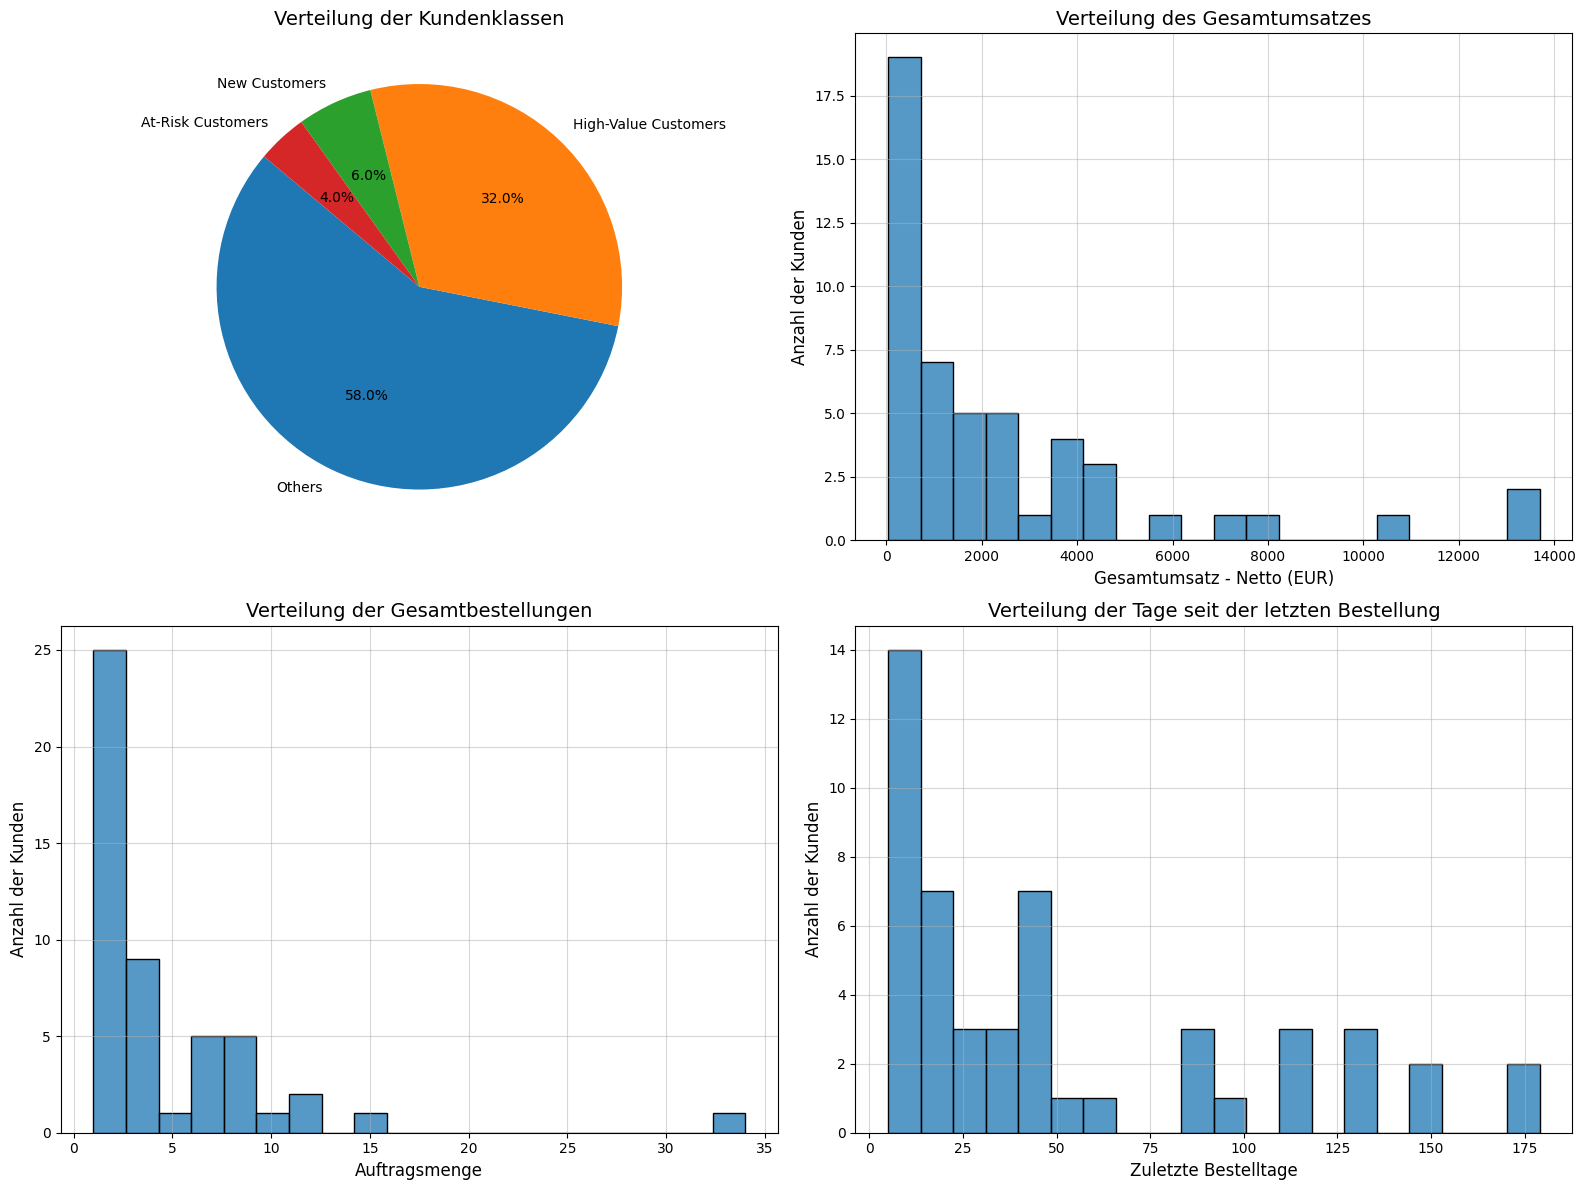

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 创建画布和子图布局
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 子图布局

# 图 1: 饼图 - Customer Segments Distribution
axes[0, 0].pie(
    segment_summary['Count'], 
    labels=segment_summary['Customer Segment'], 
    autopct='%1.1f%%', 
    startangle=140
)

axes[0, 0].set_title('Verteilung der Kundenklassen', fontsize=14)


# 图 2: 销售额分布 - Distribution of Total Sales
sns.histplot(df_customer_sales['price_subtotal'], bins=20, kde=False, ax=axes[0, 1])
axes[0, 1].set_title('Verteilung des Gesamtumsatzes', fontsize=14)
axes[0, 1].set_xlabel('Gesamtumsatz - Netto (EUR)', fontsize=12)
axes[0, 1].set_ylabel('Anzahl der Kunden', fontsize=12)
axes[0, 1].grid(alpha=0.5)

# 图 3: 订单量分布 - Distribution of Total Orders
sns.histplot(df_customer_sales['order_count'], bins=20, kde=False, ax=axes[1, 0])
axes[1, 0].set_title('Verteilung der Gesamtbestellungen', fontsize=14)
axes[1, 0].set_xlabel('Auftragsmenge', fontsize=12)
axes[1, 0].set_ylabel('Anzahl der Kunden', fontsize=12)
axes[1, 0].grid(alpha=0.5)

# 图 4: 回购率分布 - Distribution of Days Since Last Order
sns.histplot(df_customer_sales['last_order_days'], bins=20, kde=False, ax=axes[1, 1])
axes[1, 1].set_title('Verteilung der Tage seit der letzten Bestellung', fontsize=14)
axes[1, 1].set_xlabel('Zuletzte Bestelltage', fontsize=12)
axes[1, 1].set_ylabel('Anzahl der Kunden', fontsize=12)
axes[1, 1].grid(alpha=0.5)

# 调整布局并保存图表
plt.tight_layout()
plt.savefig('data/sales_chart.png')  # 保存为 PNG 文件
plt.show()


散点图：
- 上方的点：该客户很可能已经流失
- 下方的点：该客户订购比较积极。
- 左方的点：该客户为小额客户。
- 右方的点：该客户为大额客户。
- 右上方的点：该客户是大额客户，但很可能已经流失。
- 左上方的点：该客户是小额客户，且很可能已经流失。
- 右下方的点：该客户是大额客户，且很可能是忠实客户。
- 若左半边的点很大：说明客户偏向于小额频繁订购。因此我们需要花费更多的运费。
- 若左下方的点很小：该客户很可能是新客户。

In [14]:
import plotly.express as px
import pandas as pd

# 假设 df_customer_sales2 是一个 Pandas DataFrame
# df_customer_sales2['price_subtotal'], df_customer_sales2['last_order_days'], df_customer_sales2['order_count']

df_customer_sales2 = df_customer_sales.copy()  # 复制数据
# 准备数据
df_customer_sales2['size'] = df_customer_sales2['order_count'] * 100  # 点的大小
df_customer_sales2['label'] = df_customer_sales2['order_partner']  # 索引标签

# 使用 Plotly 创建交互式散点图
fig = px.scatter(
    df_customer_sales2,
    x='price_subtotal',  # 横坐标
    y='last_order_days',  # 纵坐标
    size='size',  # 点的大小
    color='order_count',  # 颜色映射
    hover_name='label',  # 鼠标悬停显示的内容
    hover_data={  # 添加其他悬停数据
        'avg_order_price': True,  # 显示 avg_order_price
        'order_count': ':.0f',  # 格式化 order_count 为整数
        'size': False,  # 不显示 size
        'tag': True  # 显示 tag
    },
    labels={
        'price_subtotal': 'Gesamt Netto (EUR)',        
        'order_count': 'Auftragsmenge',
        'avg_order_price': 'Durchschn. Auftragswert (EUR)',
        'last_order_days': 'Zuletzete Bestelltage',
        'tag': "Klasse"
    },
    title=f"Statistik zu Kundenbestellungen"
)

start_date = df_filtered_orderlines['create_date'].min().strftime('%d.%m.%Y')
end_date = df_filtered_orderlines['create_date'].max().strftime('%d.%m.%Y')
anno = f"Datenquelle: Odoo"
anno += f"<br>Zeitraum: {start_date} - {end_date}"
anno += f"<br>Anzahl Kunden: {len(df_customer_sales2)}"
anno += f"<br>Anzahl Aufträge: {df_customer_sales2['order_count'].sum()}"
anno += f"<br>Gesamtumsatz: {df_customer_sales2['price_subtotal'].sum():.2f} EUR"

# 设置布局
fig.update_layout(
    xaxis_title="Gesamtumsatz - Netto (EUR)",
    yaxis_title="Zuletzete Bestelltage",
    coloraxis_colorbar=dict(title="Auftragsmenge"), 
    template="plotly_white",
    width=1380,  # 图表的宽度（像素）
    height=500,  # 图表的高度（像素）
    annotations=[
        dict(
            text=anno,
            align="left",
            showarrow=False,
            xref="paper",  # 相对于图表的水平位置 (paper 表示相对整个图表区域)
            yref="paper",  # 相对于图表的垂直位置
            x=0.7,  # 靠近图表左侧
            y=0.9,  # 图表下方的适当位置（负值表示在图表下方）
            xanchor='left',  # 文本水平对齐方式
            yanchor='bottom',  # 文本垂直对齐方式
            font=dict(size=12, color="gray")  # 字体大小和颜色
        )
    ]
)

# 修改 y 轴刻度
fig.update_yaxes(
    tickvals=list(range(0, 300, 30))  # 设置刻度为 0, 30, 60, ..., 最大值可根据数据范围调整
)
# 保存为 HTML 文件
fig.write_html("data/customer_sales_bubble_chart.html")

# 显示图表
fig.show()


In [34]:
# 统计每一个产品的销售额 (不含运费，不含为结的)
df_product_sales = odoo_sales_orderlines.groupby(['product_name']) \
                        .agg({'price_subtotal': sum, 
                              'currency': 'first', 
                              'product_uom_qty': sum,                              
                              'uom': 'first',
                              'order_number': 'nunique'})
df_product_sales = df_product_sales.rename(columns={'order_number': 'order_count'})

df_product_sales = df_product_sales.sort_values('price_subtotal', ascending=False)
# 计算上次购买时间（天）
last_order_days = odoo_sales_orderlines.groupby('product_name')['create_date'].max().reset_index()
last_order_days['last_order_days'] = (reference_date - last_order_days['create_date']).dt.days
df_product_sales = pd.merge(df_product_sales, last_order_days[['product_name', 'last_order_days']], on='product_name', how='left')


df_product_sales_top10 = df_product_sales.head(10)
df_product_sales_bottom10 = df_product_sales.tail(10)
product_sort_by_sales = df_product_sales.reset_index()['product_name'].tolist()
df_product_sales

C:\Users\Lin\AppData\Local\Temp\ipykernel_428\3225334283.py:3: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.

C:\Users\Lin\AppData\Local\Temp\ipykernel_428\3225334283.py:3: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



,product_name,price_subtotal,currency,product_uom_qty,uom,order_count,last_order_days
0,[HG-NI100BL] HansaGT Medical® Nitril Puderfrei...,19262.90,EUR,8874.0,Pck,86,7
1,[HG-NI100BM] HansaGT Medical® Nitril Puderfrei...,17851.80,EUR,8594.0,Pck,80,7
2,[HG-346172] HighCheck THC Drogentest Speichel ...,11787.90,EUR,2460.0,Units,5,20
3,[HG-NI100BXL] HansaGT Medical® Nitril Puderfre...,5842.10,EUR,2140.0,Pck,30,7
4,[HG-NI100BS] HansaGT Medical® Nitril Puderfrei...,5684.60,EUR,2744.0,Pck,49,7
...,...,...,...,...,...,...,...
156,"[MMD-77120] 12 Stk. MaiMed-silk 2,50cm x 9,1m",11.14,EUR,1.0,Pcs,1,106
157,[AM-09592B] 100 x Med-Comfort Dental PS Einmal...,6.59,EUR,1.0,Pck,1,173
158,[DBE-1661000] Dr. Becher Reiniger für CERAN® K...,5.69,EUR,1.0,Bottle,1,148
159,Rosengarten® Elektroheizung\n•220-240V 50Hz 2000W,2.00,EUR,2.0,Pcs,2,46


In [16]:
df_customer_month_sales = odoo_sales_orderlines.groupby(['order_partner', 'month']) \
    .agg({'price_subtotal': sum,
          'currency': 'first',
          'order_number': 'nunique'})

df_customer_month_sales = df_customer_month_sales.rename(columns={'order_number': 'order_count'})
df_customer_month_sales['avg_order_price'] = df_customer_month_sales['price_subtotal'] / df_customer_month_sales['order_count']
df_customer_month_sales['avg_order_price'] = df_customer_month_sales['avg_order_price'].round(2)

# 转换 month 列为 datetime 类型
df_customer_month_sales = df_customer_month_sales.reset_index()

# 排序：先按客户顺序，再按月份
df_customer_month_sales['customer_sort'] = pd.Categorical(
    df_customer_month_sales['order_partner'],  # 获取客户名
    categories=customer_sort_by_sales,  # 自定义排序规则
    ordered=True
)

df_customer_month_sales = df_customer_month_sales.sort_values(by=['customer_sort', 'month'])
df_customer_month_sales = df_customer_month_sales.drop(columns=['customer_sort'])

# 查看前 10 行
df_customer_month_sales.head(10)


C:\Users\Lin\AppData\Local\Temp\ipykernel_428\1335706175.py:2: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



,order_partner,month,price_subtotal,currency,order_count,avg_order_price
111,Residenz Beinsen am Klosterpark Wienhausen GmbH,2024-08,2706.98,EUR,9,300.78
112,Residenz Beinsen am Klosterpark Wienhausen GmbH,2024-09,3290.36,EUR,6,548.39
113,Residenz Beinsen am Klosterpark Wienhausen GmbH,2024-10,1381.29,EUR,6,230.22
114,Residenz Beinsen am Klosterpark Wienhausen GmbH,2024-11,2758.34,EUR,5,551.67
115,Residenz Beinsen am Klosterpark Wienhausen GmbH,2024-12,2865.04,EUR,6,477.51
116,Residenz Beinsen am Klosterpark Wienhausen GmbH,2025-01,693.40,EUR,2,346.70
74,Gesundheits- und Pflegezentrum Goldenherz,2024-07,2650.38,EUR,1,2650.38
75,Gesundheits- und Pflegezentrum Goldenherz,2024-08,2093.84,EUR,1,2093.84
76,Gesundheits- und Pflegezentrum Goldenherz,2024-09,1629.66,EUR,2,814.83
77,Gesundheits- und Pflegezentrum Goldenherz,2024-10,2974.86,EUR,5,594.97


In [35]:
# 统计每个产品每个月卖出的数量和金额
df_product_month_sales = odoo_sales_orderlines.groupby(['product_name', 'month', ]) \
                            .agg({'price_subtotal': sum, 
                                  'currency': 'first', 
                                  'order_number': 'nunique'}) \
                          
df_product_month_sales = df_product_month_sales.rename(columns={'order_number': 'order_count'})
df_product_month_sales.sort_values(['product_name','month'], )
df_product_month_sales.reset_index(inplace=True)
df_product_month_sales.head(20)

C:\Users\Lin\AppData\Local\Temp\ipykernel_428\4123660372.py:3: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



,product_name,month,price_subtotal,currency,order_count
0,Rosengarten® Elektroheizung\n•220-240V 50Hz 2000W,2024-12,2.00,EUR,2
1,[AM-091561] PP Mundpflegestäbchen mit PU Schwa...,2025-01,60.76,EUR,1
2,[AM-09592B] 100 x Med-Comfort Dental PS Einmal...,2024-08,6.59,EUR,1
3,"[AM-34000] Zellstofftupfer, weiß, 4 x 5 cm, Me...",2024-09,6.86,EUR,1
4,"[AM-34000] Zellstofftupfer, weiß, 4 x 5 cm, Me...",2024-12,34.30,EUR,1
5,"[AM-34000] Zellstofftupfer, weiß, 4 x 5 cm, Me...",2025-01,51.45,EUR,1
6,"[AM-701190] Shampoohaube, weiß",2024-09,37.40,EUR,1
7,"[AM-701190] Shampoohaube, weiß",2025-01,37.40,EUR,1
8,"[AM-L09170B] PP Medizinbecher, Farbe blau, 30 ...",2024-12,56.13,EUR,1
9,"[AM-L09170G] PP Medizinbecher, Farbe gelb, 30 ...",2024-12,56.13,EUR,1


In [18]:
columns_map= {
        "order_partner": "Kunde",
        "price_subtotal": "Gesamt Netto (ERU)",
        "currency": "Währung",
        "order_count": "Auftragsmenge",
        "avg_order_price": "Durchschnittlicher Bestellpreis",
        "last_order_days": "Zuletzte Bestelltage",
        "frequency_score": "Häufigkeitsbewertung",
        "loyalty_score": "Treuepunktzahl",
        "tag": "Tag",
        "uom": "Maßeinheit",
        'product_uom_qty': 'Menge',
        "product_name": "Name",
        "month": "Monat",
    }

df_customer_sales = df_customer_sales.rename(columns= columns_map)
df_customer_month_sales = df_customer_month_sales.rename(columns=columns_map)
df_product_sales = df_product_sales.rename(columns=columns_map)
df_product_month_sales = df_product_month_sales.rename(columns=columns_map)

# Save in sheets
with pd.ExcelWriter('data/sales.xlsx') as writer:
    df_product_month_sales.to_excel(writer, sheet_name='product_month_sales')
    df_product_sales.to_excel(writer, sheet_name='product_sales', index=False)
    df_customer_month_sales.to_excel(writer, sheet_name='customer_month_sales', index=False)
    df_customer_sales.to_excel(writer, sheet_name='customer_sales', index=False)

4.1 细分客户群体
根据 RFM 得分，可以对客户进行分群：

高价值客户：忠诚度评分较高的客户（例如得分 ≥ 10）。
潜在流失客户：最近一次购买时间较久但曾经频繁购买的客户。
新客户：购买频率低但最近购买的客户。

In [19]:
df_product_sales

,Name,Gesamt Netto (ERU),Währung,Menge,Maßeinheit,Auftragsmenge,Zuletzte Bestelltage
0,[HG-NI100BL] HansaGT Medical® Nitril Puderfrei...,19262.90,EUR,8874.0,Pck,86,6
1,[HG-NI100BM] HansaGT Medical® Nitril Puderfrei...,17851.80,EUR,8594.0,Pck,80,6
2,[HG-346172] HighCheck THC Drogentest Speichel ...,11787.90,EUR,2460.0,Units,5,20
3,[HG-NI100BXL] HansaGT Medical® Nitril Puderfre...,5842.10,EUR,2140.0,Pck,30,6
4,[HG-NI100BS] HansaGT Medical® Nitril Puderfrei...,5684.60,EUR,2744.0,Pck,49,6
...,...,...,...,...,...,...,...
156,"[MMD-77120] 12 Stk. MaiMed-silk 2,50cm x 9,1m",11.14,EUR,1.0,Pcs,1,105
157,[AM-09592B] 100 x Med-Comfort Dental PS Einmal...,6.59,EUR,1.0,Pck,1,173
158,[DBE-1661000] Dr. Becher Reiniger für CERAN® K...,5.69,EUR,1.0,Bottle,1,148
159,Rosengarten® Elektroheizung\n•220-240V 50Hz 2000W,2.00,EUR,2.0,Pcs,2,45


# 获得采购成本

### 获得所有的Bestellung


In [38]:
domain = [('partner_id', 'not in', [39, 316])]
order_ids = cli.search('purchase.order', [domain])
orders_ = cli.read('purchase.order', [order_ids])
print(len(order_ids))
print(orders_[0])

81
{'id': 97, 'activity_ids': [], 'activity_state': False, 'activity_user_id': False, 'activity_type_id': False, 'activity_type_icon': False, 'activity_date_deadline': False, 'my_activity_date_deadline': False, 'activity_summary': False, 'activity_exception_decoration': False, 'activity_exception_icon': False, 'activity_calendar_event_id': False, 'message_is_follower': True, 'message_follower_ids': [5092, 5125], 'message_partner_ids': [3, 43], 'message_ids': [13435, 13431, 13430, 13421, 13360], 'has_message': True, 'message_needaction': False, 'message_needaction_counter': 0, 'message_has_error': False, 'message_has_error_counter': 0, 'message_attachment_count': 17, 'rating_ids': [], 'website_message_ids': [13435, 13431], 'message_has_sms_error': False, 'access_url': '/my/purchase/97', 'access_token': '2403bc8b-47a3-40de-a180-0f6f19b188ee', 'access_warning': '', 'name': 'BE250009701', 'priority': '0', 'origin': 'Auffüllbericht', 'partner_ref': False, 'date_order': '2025-01-20 12:00:00'

In [39]:
orders_[10]

{'id': 85,
 'activity_ids': [],
 'activity_state': False,
 'activity_user_id': False,
 'activity_type_id': False,
 'activity_type_icon': False,
 'activity_date_deadline': False,
 'my_activity_date_deadline': False,
 'activity_summary': False,
 'activity_exception_decoration': False,
 'activity_exception_icon': False,
 'activity_calendar_event_id': False,
 'message_is_follower': True,
 'message_follower_ids': [4735, 4737],
 'message_partner_ids': [3, 49],
 'message_ids': [13113,
  13112,
  13111,
  13110,
  13109,
  13053,
  13050,
  13047,
  13046,
  11730,
  11729,
  11726,
  11725],
 'has_message': True,
 'message_needaction': False,
 'message_needaction_counter': 0,
 'message_has_error': False,
 'message_has_error_counter': 0,
 'message_attachment_count': 2,
 'rating_ids': [],
 'website_message_ids': [11730],
 'message_has_sms_error': False,
 'access_url': '/my/purchase/85',
 'access_token': '60fcecdf-731b-4342-bb2b-014a2daedaa6',
 'access_warning': '',
 'name': 'BE250008501',
 'pri

In [40]:
# 获取所有orderline的id
order_line_ids = set()
for od in orders_:
    order_line_ids.update(od['order_line'])

order_line_ids = list(order_line_ids)
print(f"Length: {len(order_line_ids)}")
print(order_line_ids[:10])

Length: 256
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [41]:
orderlines_ = cli.read('purchase.order.line', [order_line_ids])
orderlines_[50]

{'id': 60,
 'analytic_distribution': False,
 'analytic_distribution_search': False,
 'analytic_precision': 2,
 'name': '[700541] 500 ml Lotio Med Soft Professional & Care Waschlotion',
 'sequence': 10,
 'product_qty': 36.0,
 'product_uom_qty': 36.0,
 'date_planned': '2024-09-06 12:00:00',
 'discount': 0.0,
 'taxes_id': [25],
 'product_uom': [27, 'Bottle'],
 'product_uom_category_id': [1, 'Unit'],
 'product_id': [1238,
  '[DDE-700541] 500 ml Lotio Med Soft Professional & Care Waschlotion'],
 'product_type': 'product',
 'price_unit': 1.36,
 'price_unit_discounted': 1.36,
 'price_subtotal': 48.96,
 'price_total': 58.26,
 'price_tax': 9.3,
 'order_id': [23, 'BE240002308'],
 'company_id': [1, 'HansaGT Medical GmbH'],
 'state': 'purchase',
 'invoice_lines': [],
 'qty_invoiced': 0.0,
 'qty_received_method': 'stock_moves',
 'qty_received': 36.0,
 'qty_received_manual': 0.0,
 'qty_to_invoice': 36.0,
 'partner_id': [41, 'Laboratorium Dr.Deppe GmbH'],
 'currency_id': [126, 'EUR'],
 'date_order': 

In [42]:
purchase_orders = []
for od in orders_:
    so = dict(
        id = od['id'],
        name = od['name'],
        company = od['company_id'][1],
        partner = od['partner_id'][1],
        state = od['state'],
        date_order = od['date_order'],
        invoice_status = od['invoice_status'],        
        # shipping_weight = od['shipping_weight'],
        orderline_ids = od['order_line']
    )
    purchase_orders.append(so)

print(f"Number of orders: {len(purchase_orders)}")
df_purchase_orders = pd.DataFrame.from_dict(purchase_orders)
df_purchase_orders.to_excel("data/purchase_orders.xlsx", index=False)

Number of orders: 81


In [43]:
orderlines = []

for odl in orderlines_: 
    # print(odl)   
    if odl['display_type'] == 'line_note':
        continue
    line = {
        "order_number": odl['order_id'][1],  # 订单号
        "product_name": odl['name'],  
        "currency": odl['currency_id'][1], 
        "order_partner": odl['partner_id'][1], # 客户
        # "salesman": odl['salesman_id'][1], # 销售员
        'state': odl['state'], 
        'uom': odl['product_uom'][1],  # 单位
        'product_uom_qty': odl['product_uom_qty'],   #product_qty
        'product_qty': odl['product_qty'],  # 数量
        'price_unit': odl['price_unit'],  # 单价
        'price_subtotal': odl['price_subtotal'], # 小计
        'price_tax': odl['price_tax'], # 含税
        'price_total': odl['price_total'], # 总计
        'qty_to_invoice': odl['qty_to_invoice'], 
        'qty_received': odl['qty_received'],
        'date_order': odl['date_order'],
        'product_type': odl['product_type'],
        'create_date': odl['create_date'],
        'discount': odl['discount'],               
    }

    orderlines.append(line)

# print(len(orderlines))
# orderlines[10]

df_purchase_order_lines = pd.DataFrame.from_dict(orderlines)
df_purchase_order_lines['create_date'] = pd.to_datetime(df_purchase_order_lines['create_date'], format='%Y-%m-%d %H:%M:%S')
df_purchase_order_lines.sort_values(by='create_date', inplace=True)
df_purchase_order_lines.to_excel('data/purchase_order_lines.xlsx')

In [44]:
import datetime
# 数据清洗

# 被取消的orderlines
df_filtered_purchase_orderlines = df_purchase_order_lines[df_purchase_order_lines['state']== 'purchase']

# product_type == product
df_filtered_purchase_orderlines = df_filtered_purchase_orderlines[df_filtered_purchase_orderlines['product_type'] == 'product']

# 订单中所有商品的qty_received == product_uom_qty
qty_all_received = df_filtered_purchase_orderlines['qty_received'] == df_filtered_purchase_orderlines['product_uom_qty']
# df_filtered_purchase_orderlines = df_filtered_purchase_orderlines[qty_all_received]

# price_unit != 0
df_filtered_purchase_orderlines = df_filtered_purchase_orderlines[df_filtered_purchase_orderlines['price_unit']!= 0]

df_filtered_purchase_orderlines['year'] = df_filtered_purchase_orderlines['create_date'].dt.strftime('%Y')
df_filtered_purchase_orderlines['month'] = df_filtered_purchase_orderlines['create_date'].dt.strftime('%Y-%m')

df_filtered_purchase_orderlines.to_excel('data/purchase_order_lines.xlsx')
print(len(df_filtered_purchase_orderlines))

229


In [45]:
# 统计每个产品的采购价
odoo_purchase_orderlines = df_filtered_purchase_orderlines.copy()
odoo_purchase_orderlines.head(5)


,order_number,product_name,currency,order_partner,state,uom,product_uom_qty,product_qty,price_unit,price_subtotal,price_tax,price_total,qty_to_invoice,qty_received,date_order,product_type,create_date,discount,year,month
0,BE240000207,[HG-TEST01] Just for testing 1,EUR,Meditrade,purchase,Pck,1.0,1.0,0.12,0.12,0.02,0.14,1.0,1.0,2024-07-24 09:16:35,product,2024-07-24 09:16:41,0.0,2024,2024-07
1,BE240000307,[601302] 500 ml Lotio Sept Basic- OA Händedesi...,EUR,Laboratorium Dr.Deppe GmbH,purchase,Bottle,36.0,36.0,1.13,40.68,7.73,48.41,36.0,36.0,2024-07-24 12:00:00,product,2024-07-24 13:19:18,0.0,2024,2024-07
2,BE240000307,[700121] 200 ml Lotio Aktiv Professional - küh...,EUR,Laboratorium Dr.Deppe GmbH,purchase,Tube,12.0,12.0,1.73,20.76,3.94,24.70,12.0,12.0,2024-07-24 12:00:00,product,2024-07-24 13:19:18,0.0,2024,2024-07
3,BE240000307,[700541] 500 ml Lotio Med Soft Professional & ...,EUR,Laboratorium Dr.Deppe GmbH,purchase,Bottle,18.0,18.0,1.36,24.48,4.65,29.13,0.0,0.0,2024-07-24 12:00:00,product,2024-07-24 13:19:18,0.0,2024,2024-07
4,BE240000307,[700575] 500 ml Lotio Protect Professional & C...,EUR,Laboratorium Dr.Deppe GmbH,purchase,Bottle,18.0,18.0,4.55,81.90,15.56,97.46,18.0,18.0,2024-07-24 12:00:00,product,2024-07-24 13:19:18,0.0,2024,2024-07


In [59]:
# 统计出每个产品的采购价
df_product_cost = odoo_purchase_orderlines.groupby(['product_name']) \
                            .agg({'price_unit': ['mean', 'first', 'last', 'min', 'max'], 
                                  'currency': 'first', 
                                  'product_name':  'count',
                                  'product_uom_qty': 'sum'}) 

df_product_cost.columns = ['_'.join(col).strip() for col in df_product_cost.columns]
print(len(df_product_cost))
df_product_cost.reset_index(inplace=True)
df_product_cost.sample(10)

143


,product_name,price_unit_mean,price_unit_first,price_unit_last,price_unit_min,price_unit_max,currency_first,product_name_count,product_uom_qty_sum
122,"[MCT-RD20018002] VINYLEX PF, Vinyl Handschuhe,...",1.55,1.55,1.55,1.55,1.55,EUR,1,500.0
81,[601107] Spray In QF,23.65,23.65,23.65,23.65,23.65,EUR,2,32.0
113,[DSM-004570P010] ASEPTOMAN®MED Händedesinfekti...,4.53,4.53,4.53,4.53,4.53,EUR,1,84.0
28,"[01034200] melinip Schnabelbecher ECO, Breidec...",5.40,5.40,5.40,5.40,5.40,EUR,2,10.0
137,[SN-SE091SB25D03] Seni Soft Basic 90 cm x60 cm...,5.17,5.17,5.17,5.17,5.17,EUR,2,160.0
115,[HG-NI100BL] HansaGT Medical® Nitril Puderfrei...,1.60,1.60,1.60,1.60,1.60,EUR,1,12000.0
30,"[01034206] melinip Schnabelbecher ECO, Breidec...",5.40,5.40,5.40,5.40,5.40,EUR,1,6.0
125,[MPM- A21210014] MP Med® Andickungspulver PLUS...,11.49,11.49,11.49,11.49,11.49,EUR,1,36.0
20,"[00077580] MaiMed-stretch 5cm x 10m, 1 St./Box",1.15,1.15,1.15,1.15,1.15,EUR,3,180.0
9,"[00025070] MaiMed-MK-steril 10x10cm 8-f., 25x2...",2.37,2.37,2.37,2.37,2.37,EUR,1,600.0


In [62]:
df_merged = df_sale_order_lines.merge(df_product_cost[["product_name", "price_unit_last"]], on="product_name", how="left")
df_merged.sample(10)
df_merged.to_excel("data/gross_profit.xlsx", index=False)

,order_number,product_name,currency,order_partner,salesman,state,uom,product_uom_qty,product_qty,price_unit,price_subtotal,price_tax,price_total,qty_to_invoice,qty_to_deliver,product_type,create_date,is_delivery,price_unit_last
30,AB240527407,[HG-NI100BM] HansaGT Medical® Nitril Puderfrei...,EUR,Senioren- und Pflegeheim Elbuferpark,Alexander Haliw,sale,Pck,30.0,30.0,2.05,61.50,11.69,73.19,0.0,0.0,product,2024-07-30 11:26:50,False,NaN
629,AB240551412,"[HG-BKPP10] 10 x PP-Schutzkittel 23g, blau, 12...",EUR,Residenz Beinsen am Klosterpark Wienhausen GmbH,Alexander Haliw,sale,Pck,20.0,20.0,4.19,83.80,15.92,99.72,0.0,0.0,product,2024-12-02 15:00:23,False,NaN
191,AB240534109,[DBE-1410000] Glas- und Interieur Reiniger 750ml,EUR,Residenz Beinsen am Klosterpark Wienhausen GmbH,Alexander Haliw,sale,Units,1.0,1.0,0.00,0.00,0.00,0.00,0.0,0.0,product,2024-09-02 14:15:44,False,NaN
140,AB240532308,[HG-M2003] 25 x HansaGT Medical® Einweg-Bettsc...,EUR,Die Wohngruppe Segeberg für Jüngere Bewegungsb...,Alexander Haliw,sale,Pck,12.0,12.0,7.99,95.88,18.22,114.10,0.0,0.0,product,2024-08-26 08:48:53,False,NaN
471,AB240545310,"[HG-HLSKA25] Kanülenabwurfbehälter 2,5L\n60 St...",EUR,Gesundheits- und Pflegezentrum Goldenherz,Alexander Haliw,sale,Pcs,10.0,10.0,1.95,19.50,3.71,23.21,0.0,0.0,product,2024-10-30 10:21:32,False,NaN
845,AB250559701,Versandkostenpauschale,EUR,BLD Pharmatech GmbH,Clara C. Chen,sale,Units,1.0,1.0,9.99,9.99,1.90,11.89,0.0,1.0,service,2025-01-13 13:02:14,True,NaN
224,AB240535109,"[DDE-900080] XXL - Rolle 70 Blatt, 100 % Cellu...",EUR,Diakoniestiftung Alt-Hamburg - Ev. Altenwohnhe...,Alexander Haliw,sale,Pck,30.0,30.0,4.49,134.70,25.59,160.29,0.0,0.0,product,2024-09-09 09:12:00,False,NaN
175,AB240532908,[HG-NI100BL] HansaGT Medical® Nitril Puderfrei...,EUR,"tesa Werk Hamburg GmbH, tphh.indirects",Clara C. Chen,sale,Pck,60.0,60.0,9.00,540.00,102.60,642.60,0.0,0.0,product,2024-08-28 14:36:55,False,NaN
850,AB250559901,Versandkostenpauschale,EUR,The Alley Frankfurt GmbH,Alexander Haliw,sale,Units,1.0,1.0,9.99,9.99,1.90,11.89,0.0,1.0,service,2025-01-13 14:02:09,True,NaN
170,AB240532608,[MPM- A21210014] MP Med® Andickungspulver PLUS...,EUR,Alten- und Pflegeheim St. Elisabeth,Alexander Haliw,sale,Bucket,5.0,5.0,15.99,79.95,15.19,95.14,0.0,0.0,product,2024-08-27 12:11:53,False,11.49
